# Relationship Between Goals Scored and Transfer Market Value
#### Abraham Austin, Samuel McIlrath, Francisco Rodriguez Sanchez | MATH 263
##### April 24, 2025

## Introduction
### Topic:
For our project, we will explore soccer player's transfer market values. In professional soccer, a player's transfer value represents the estimated fee one club must pay another to acquire a player. While many factors go into a player’s price, typically, the better the player the better the price. In order to focus our vision, we want to hone in on attacking players, and look at the relationship between a player's stats in a season and their transfer values. This is mainly because in the world of soccer, each position on the field tend to has its own market range, with goalies, centerbacks, attacking midfielders, all having their own set of prices. By reducing our scope to only attackers we can hopefully make a more accurate model through linear regression.

Our goal is to create a model that evaulates different attributes and their impact on a player's transfer market value for the 2017/2018 season.

### Data:
Our sample data comes from the Kaggle dataset found at: https://www.kaggle.com/datasets/kriegsmaschine/soccer-players-values-and-their-statistics This dataset contains the player values and statistics of players for the 2017/2018 season but we will be looking specifically at players who are classified in attacking positions. This dataset is a compilation of information from transfermarkt.de and fbref.com which provide very in depth soccer statistics for players across the top 5 leagues. This dataset is extremely verbose so we will limit ourselves to a range of attributes that are typically associated with attacker play and are as follows:

- **Goals**:  
  The total number of goals scored by a player over the course of the 2017/2018 season.

- **Assists**:  
  The total number of assists made by a player, which typically is the final pass or action leading directly to a teammate scoring a goal.

- **Expected Goals**:  
  A metric that estimates the likelihood of a shot resulting in a goal based on factors like shot angle, distance, and assist type. xG helps assess finishing efficiency beyond raw goal count.

- **Expected Assists**:  
  Similar to xG, xA estimates the quality of a pass leading to a shot, regardless of whether the shot resulted in a goal. It captures creative passing contributions.

- **Total Shots per 90 Minutes**:  
  The average number of shots a player takes per 90 minutes of play, normalized to compare players regardless of playing time.

- **Shots on Target Percentage**:  
  The percentage of a player's total shots that are on target (i.e., require a save or result in a goal). This gives insight into shooting accuracy.

- **Dribbles Completed Percentage**:  
  The percentage of attempted dribbles a player successfully completes. It reflects a player's ability to beat defenders one-on-one.


_**NOTE**: After cross referencing with other sites, this data consists of the statistics of a player's club season in only their domestic league. This means that player stats from club tournaments (Champions League, FA Cup, etc) and national team competitions are NOT included in the dataset._

Before we can engage and tackle our problem we need to clean up the dataset so that we are only working with the information that is relevant to our research. This included ensuring unique samples, grabbing only players that identified as attackers, as well as dropping columns that aren't associated with actions typical for attackers (defensive play).

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [51]:
# load csv to dataframe
df = pd.read_csv("raw/transfermarkt_fbref_201718.csv", sep = ';')

#rename first column to id
if df.columns[0] == '' or df.columns[0].startswith('Unnamed'):
    df = df.rename(columns={df.columns[0]: 'id'})

In [52]:
n_obs = len(df)
n_unique_ids = df['id'].nunique()
print(f"Total observations: {n_obs}")
print(f"Unique IDs:        {n_unique_ids}")
assert n_obs == n_unique_ids, "some IDs are not unique!"

Total observations: 2232
Unique IDs:        2232


## Exploratory Data Analysis
After selecting only players whose position contains “FW” (forward), we were initially left with 825 entries. When lookign through those statistics, it became apparent there’s a huge range of talent here in the data set. For example there are squad players who barely see the pitch to ultra-expensive stars like Lionel Messi. Players’ transfer values spanned from under €5000 all the way up to nearly €180 M. Goal totals ranged from 0 to 34 (though most forwards fall below 10 goals). 

Considering this, we decided to reduce our scope once again to jsut attackers who have played at least 25% of minutes in a season to try and get rid of the skewedness. Even after doing this our data is rather skewed but better than it was before.

In [53]:
#Get only the attacking players
fw_players = df[df['position'].str.contains("FW", na=False)]

#remove players with less than 25% of the season minutes
#Assuming 38 games in the season and 90 minutes per game
season_minutes = 38*90
cutoff = 0.25*season_minutes
fw_players = fw_players[fw_players["minutes"] >= cutoff]

fw_obs = len(fw_players)
print(f"Total FW observations: {fw_obs}")

#get attacking stats columns))
result = fw_players[["player", "goals","assists", "xg", "xa", "shots_total_per90", "shots_on_target_pct", "dribbles_completed_pct","value"]]
print("\nDescriptive statistics for attacking players:\n", result.describe().T)


Total FW observations: 473

Descriptive statistics for attacking players:
                         count          mean           std       min  \
goals                   473.0  5.885835e+00  5.612455e+00      0.00   
assists                 473.0  3.086681e+00  2.665475e+00      0.00   
xg                      473.0  5.699789e+00  4.552921e+00      0.40   
xa                      473.0  3.062791e+00  2.263306e+00      0.20   
shots_total_per90       473.0  2.188140e+00  8.567065e-01      0.42   
shots_on_target_pct     473.0  3.633911e+01  9.456948e+00      0.00   
dribbles_completed_pct  473.0  5.741564e+01  1.244694e+01      0.00   
value                   473.0  1.794181e+07  2.622994e+07  25000.00   

                              25%         50%          75%           max  
goals                         2.0        4.00         8.00  3.400000e+01  
assists                       1.0        2.00         5.00  1.500000e+01  
xg                            2.6        4.40         7.70  

As previously mentioned, our data appears to be right skewed across the board, with a lot of our means holding smaller values. The mean goals is around 4 and the smallest standard deviation we have is in the total shots per 90 miniutes category, which gets closer to 0 than the others. While most of our data is clustered towards 0, it's clear that the top players in the game are really stretching out the data and there's a decent number of them as well. To better visualize this, let's take a look at player value and goals in box plots.

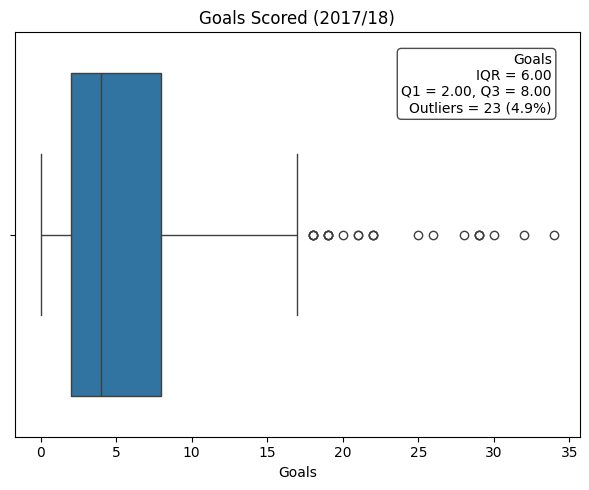

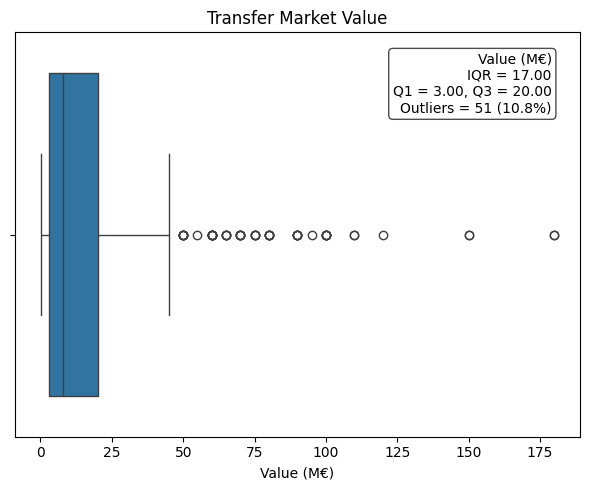

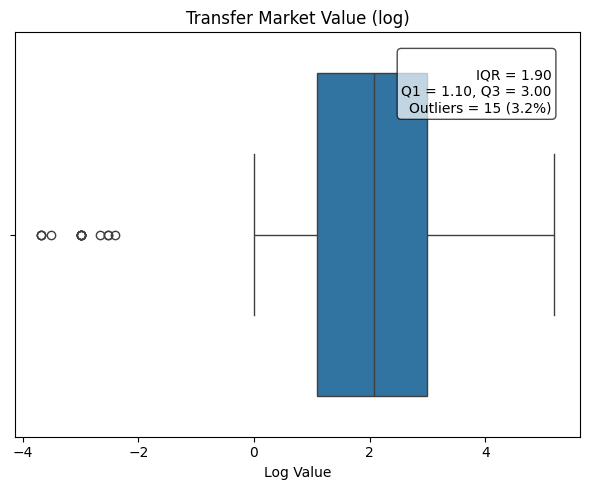

In [54]:
fw = fw_players.copy()
fw['value_m_eur'] = fw["value"]/1e6

# log transform the value column
# to reduce skewness
fw['log_value'] = np.log(fw['value_m_eur'])

def annotate_box(ax, data, label):
    q1, q3 = np.quantile(data, [0.25, 0.75])
    iqr = q3 - q1
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr
    # count outliers
    is_out = (data < lower_fence) | (data > upper_fence)
    n_out = is_out.sum()
    pct_out = 100 * n_out / len(data)
    
    text = (
        f"{label}\n"
        f"IQR = {iqr:.2f}\n"
        f"Q1 = {q1:.2f}, Q3 = {q3:.2f}\n"
        f"Outliers = {n_out} ({pct_out:.1f}%)"
    )
    ax.text(
        0.95, 0.95, text,
        transform=ax.transAxes,
        ha='right', va='top',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7)
    )

# 1) Goals
plt.figure(figsize=(6, 5))
sns.boxplot(x=fw["goals"])
plt.title("Goals Scored (2017/18)")
plt.xlabel("Goals")
annotate_box(plt.gca(), fw["goals"], "Goals")
plt.tight_layout()
plt.show()

# 2) Transfer value (in M€)
plt.figure(figsize=(6, 5))
sns.boxplot(x=fw["value_m_eur"])
plt.title("Transfer Market Value")
plt.xlabel("Value (M€)")
annotate_box(plt.gca(), fw["value_m_eur"], "Value (M€)")
plt.tight_layout()
plt.show()

# 3) Log‐transformed transfer value
plt.figure(figsize=(6, 5))
sns.boxplot(x=fw["log_value"])
plt.title("Transfer Market Value (log)")
plt.xlabel("Log Value")
annotate_box(plt.gca(), fw["log_value"], "")
plt.tight_layout()
plt.show()

Here we can clearly see what we've previously discussed. For both of these categories, most of the records report values closer to 0 and this leaves us with a substantial amount of outliers. With player value, more than 10% of our attackers are considered to be an outlier for their player value. We have a large amount of variation within our dataset, even after manipulating to hopefully narrow things down.

The Goals Scored boxplot shows that most attackers score few goals and a small number achieve significantly higher scores. Similarly, the Transfer Market Value boxplot is highly skewed to the right, showing that most players have relatively low values while a few stars have exceptionally high market values, which creates outliers and skews in the graph. The log transformed Transfer Value boxplot reduces skewness, resulting in a more symmetric distribution with fewer outliers.

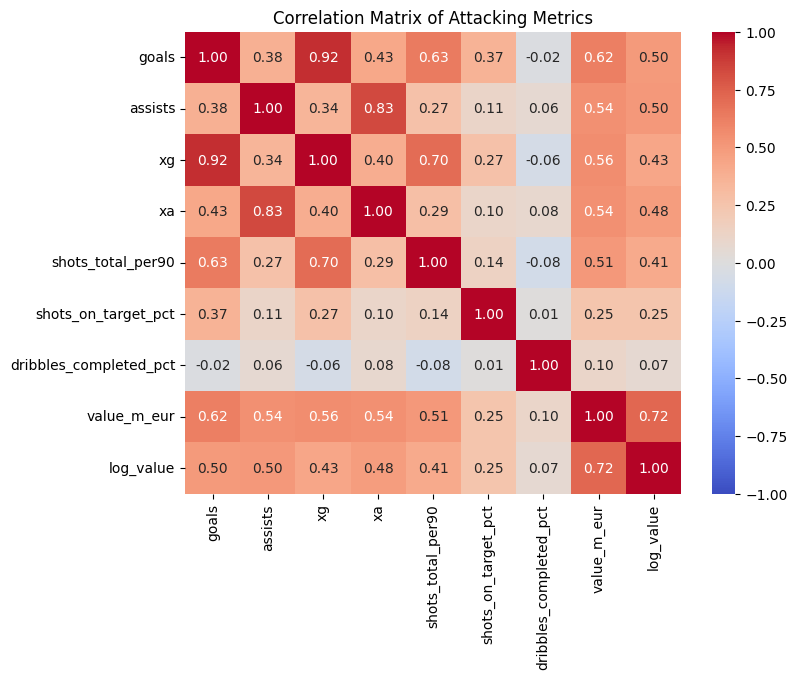

In [55]:
cols = ["goals", "assists", "xg", "xa", "shots_total_per90", "shots_on_target_pct", "dribbles_completed_pct", "value_m_eur", "log_value"]
corr = fw[cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix of Attacking Metrics")
plt.show()

#### Correlation Coefficient
Looking at all of the correlation coefficients for the attributes in one square, we can look at the bottom row to see the coefficients between value and the attributes we are observing. Of the attributes that we are analyzing it seems that goals, assists, xg, and xa, are the only attributes with any sort of correlation to player value. Goals and asissts make logical sense here. In order to win games you must score goals and in order to score goals someone typically must pass to them, so it makes sense that attacking players who record more goals and assists would therefore have higher values as they do what it takes to win games. Xa and xa unsurprisingly follow goals and assits as these attributes are closely tied together. Typically when a player has a higher xg/xa stat, it's safe to assume that some of those expected goals/asissts actually turned into goals/assits.

Apart from those four, in isolation, the other attributes we've included don't appear to play too much of a role in determining the variance of player value.


We can also see there is decrease in correlation for the log transformed transfer market value for each of predictors in comparison to the value_m_euros. This tells us that the data is the high correlation on the euro scale was largely thanks to a few very expensive players. Thought the correlation coefficient shows less strength in the relationship between goals and transfer market value, it is more accurate.

### Building Regression Lines

Before we attempt to use all of the attributes we've selected, let's first look at what the regression line would look like by only using goals as the predictor for the model.

R-squared (original): 0.39
Slope: 0.13
Intercept: 1.21
Correlation coefficient (r): 0.50
Coefficient of determination (r^2): 0.25


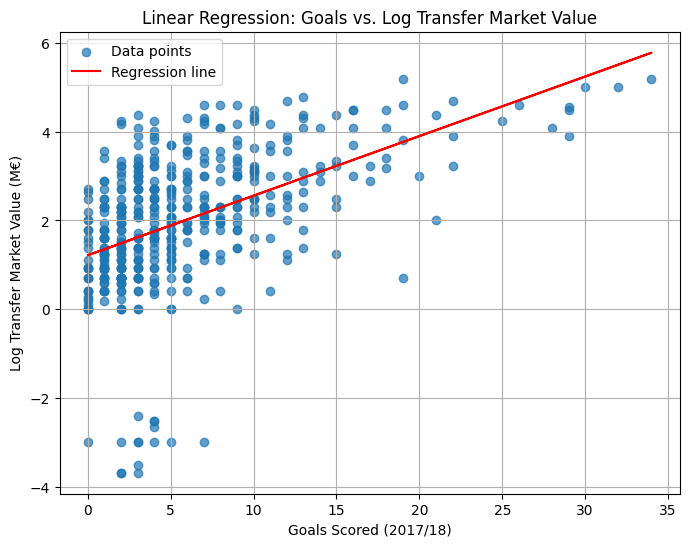

In [56]:
from scipy.stats import linregress

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(fw['goals'], fw['log_value'])

# Perform linear regression on log-transformed values
slope1, intercept1, r_value1, p_value1, std_err1 = linregress(fw['goals'], fw['value_m_eur'])


# Calculate r^2
r_squared = r_value**2
r_squared1 = r_value1**2
print(f"R-squared (original): {r_squared1:.2f}")


# Display the regression results
print(f"Slope: {slope:.2f}")
print(f"Intercept: {intercept:.2f}")
print(f"Correlation coefficient (r): {r_value:.2f}")
print(f"Coefficient of determination (r^2): {r_squared:.2f}")

# Plot the regression line
plt.figure(figsize=(8, 6))
plt.scatter(fw['goals'], fw['log_value'], alpha=0.7, label="Data points")
plt.plot(fw['goals'], slope * fw['goals'] + intercept, color='red', label="Regression line")
plt.xlabel("Goals Scored (2017/18)")
plt.ylabel("Log Transfer Market Value (M€)")
plt.title("Linear Regression: Goals vs. Log Transfer Market Value")
plt.legend()
plt.grid(True)
plt.show()

The correlation coefficient (r = 0.5) measures the strength and direction of the linear relationship between goals scored and transfer value. The coefficient of determination (r^2 = 0.25) indicates that approximately 25% of the variance in transfer value can be explained by the number of goals scored.

Let's now see if adding other attributes increases our coefficient.

In [66]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

otherAttributes = ["goals", "assists", "xg", "xa", "shots_total_per90", "shots_on_target_pct", "dribbles_completed_pct", "log_value"]
dataWithIncreaseAttributes= fw[otherAttributes]
X = dataWithIncreaseAttributes.drop(["log_value"], axis=1)
Y = dataWithIncreaseAttributes[["log_value"]]

# Split to train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, fw['log_value'], test_size=.2, random_state=42)

# Create and train the model
model = LinearRegression()
model.fit(X_train, Y_train)

# Predict on test set
predictions = model.predict(X_test)

# Evaluate the model
r2 = r2_score(Y_test, predictions)
print("R^2 Score:", r2)

R^2 Score: 0.39529936534185595


It seems that by adding more dimensions to our regression model we have significantly increased our r^2 score. So there's still hope, if we do a multiple regression with more relevant attributes, we could see and even higher increase. From our work until this point, it appears that there are attributes that have a correlation with player value so let's go back to the drawing board to reevalute what columns we are picking as our market price drivers and what model we use to build our line.

## Multiple Linear Regression

After learning about multiple linear regression, we have decided to expand the attributes we are considering and narrow down our regression line to only include those that are impactful.

In [67]:
import statsmodels.api as sm

predictors = [
    "age",                    # age yrs
    "height",                 # ht cm

    "goals",                  # total goals
    "assists",                # total assists
    "xg",                     # expected goals
    "xa",                     # expected assists

    "minutes",

    "passes_pct",             # pass success
    "passes_progressive_distance",  # prog pass dist
    "progressive_passes",     # prog pass count
    "passes_into_penalty_area",  # passes into box
    "passes_received",  # passes received
    "pass_targets",  # pass targets
    "passes_completed",        # passes completed

    "dribbles_completed_pct", # dribble success
    "carry_progressive_distance",  # carry dist


    "aerials_won",        # aerial success
    "cards_yellow",            # yellow cards
    "cards_red",               # red cards
    "fouled",             # fouls drawn
    "fouls",         # fouls committed
    "offsides",
    "dispossessed",        # dispossessed
]

X = fw[predictors]
y = fw["log_value"]


# add constant for intercept
X_const = sm.add_constant(X)

model1 = sm.OLS(y, X_const).fit()
print(model1.summary())


                            OLS Regression Results                            
Dep. Variable:              log_value   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     29.10
Date:                Fri, 02 May 2025   Prob (F-statistic):           2.69e-74
Time:                        19:14:11   Log-Likelihood:                -651.30
No. Observations:                 473   AIC:                             1351.
Df Residuals:                     449   BIC:                             1450.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

**What’s happening in this regression**  
By including multiple predictors in our regression model, we aim to assess whether each player statistic—such as age, goals, expected goals, passes, and so on—contributes to explaining the variance in the log-transformed transfer market value. Each predictor’s coefficient represents the expected change in log transfer value (in millions of euros) associated with a one‐unit change in that stat. We, also, look at the statistical significance of each predictor via its p-value. Predictors with a p-value above 0.05 are considered statistically insignificant and are removed through a loop. This is keep the most impactful predictors transfer market value for a player.

In [70]:
def trim_predictors(X, y):
    X = sm.add_constant(X)
    while True:
        model = sm.OLS(y, X).fit()
        pvals = model.pvalues.drop("const")
        max_p = pvals.max()
        if max_p > 0.05:
            worst = pvals.idxmax()
            print(f"Dropping '{worst}' (p={max_p:.3f})")
            X = X.drop(columns=[worst])
        else:
            break
    return model

best_model = trim_predictors(fw[predictors], fw["log_value"])
print(best_model.summary())

Dropping 'fouled' (p=0.921)
Dropping 'xg' (p=0.894)
Dropping 'height' (p=0.857)
Dropping 'offsides' (p=0.852)
Dropping 'fouls' (p=0.652)
Dropping 'cards_red' (p=0.504)
Dropping 'progressive_passes' (p=0.318)
Dropping 'carry_progressive_distance' (p=0.278)
Dropping 'passes_received' (p=0.411)
Dropping 'dribbles_completed_pct' (p=0.262)
Dropping 'pass_targets' (p=0.260)
Dropping 'passes_pct' (p=0.223)
Dropping 'xa' (p=0.244)
Dropping 'aerials_won' (p=0.141)
                            OLS Regression Results                            
Dep. Variable:              log_value   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     73.61
Date:                Fri, 02 May 2025   Prob (F-statistic):           1.33e-83
Time:                        20:10:24   Log-Likelihood:                -657.05
No. Observations:                 473   AIC:                      

**What’s happening in backward elimination**  

1. Start with all predictors plus an intercept
2. Fit the OLS model and grab each predictor’s p-value
3. Find the predictor with the highest p-value
   - If it’s above 0.05, drop it 
   - Repeat the cycle until all predictors have p <= 0.05.  


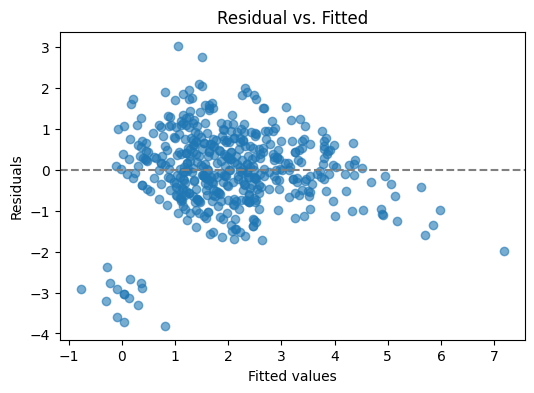

In [72]:
resid = best_model.resid
fitted = best_model.fittedvalues

plt.figure(figsize=(6,4))
plt.scatter(fitted, resid, alpha=0.6)
plt.axhline(0, color="grey", linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residual vs. Fitted")
plt.show()

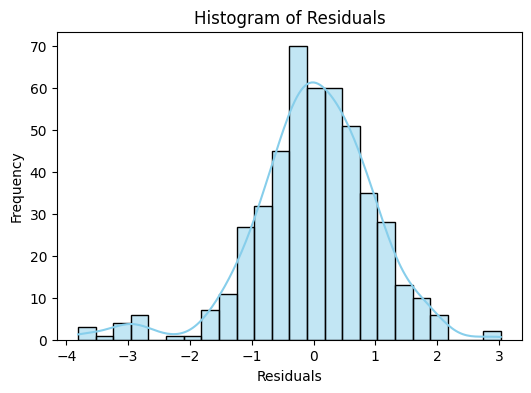

In [75]:
plt.figure(figsize=(6,4))
sns.histplot(best_model.resid, kde=True, color='skyblue')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

**Residuals**  
The residual vs. fitted plot shows that most residuals cluster around zero, meaning that the predictions are generally correct. The histogram of residuals reveals a roughly symmetrical distribution centered at zero with a bell-shaped curve. This also affirms the assumption of normally distributed errors. However, there seem to be a few noticeable ouliers.

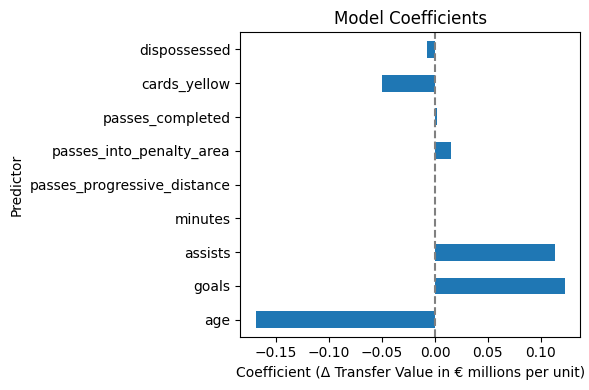

In [76]:

actual = fw["value_m_eur"]
pred = best_model.fittedvalues

plt.figure(figsize=(6,4))
coef = best_model.params.drop("const")
coef.plot(kind="barh")
plt.xlabel("Coefficient (Δ Transfer Value in € millions per unit)")
plt.ylabel("Predictor")
plt.title("Model Coefficients")
plt.axvline(0, color="grey", linestyle="--")
plt.tight_layout()
plt.show()

In [ ]:
coefs = best_model.params.drop("const")
top5 = coefs.abs().sort_values(ascending=False)
print("\nTop predictors by coef:")
for name, _ in top5.items():
    print(f"{name}: {coefs[name]:.3f}")


Top predictors by |coef|:
age: -0.169
goals: 0.122
assists: 0.113
cards_yellow: -0.050
passes_into_penalty_area: 0.015
dispossessed: -0.008
passes_completed: 0.002
minutes: -0.000
passes_progressive_distance: -0.000


### Quick Summary of Predictors

- **Goals** have a strong positive impact on log transfer market value
- **Assists** are also positively drive value 
- **Age** is a negative predictor, which means that older players tend to have lower transfer values 

### Overall Conclusion

Our analysis shows that the attacker’s performance is linked to their transfer market value. Starting with a simple linear regression using only goals, we observed a moderate correlation. When we expanded to multiple predictors and refining the model by eliminating statistically insignificant predictors, we improved the r^2. The final model includes the attributes: goals, assists, and age and residuals charts show a consistent fit. Overall, these insights can help clubs and analysts better understand key performance drivers and their impact on player valuation in a competitive market.